In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pyrex
#import pyrex.custom.ara as ara
from pyrex.internal_functions import normalize
import os
import sys
import seaborn as sns
import polReco_util as util
import scipy

import ROOT
from ROOT import TCanvas, TGraph
from ROOT import gROOT
from ROOT import gInterpreter, gSystem
from ROOT import TChain, TSelector, TTree
from scipy.stats import norm
from scipy.stats import rayleigh

#add headers from AraSim. Not sure if all of them are needed, and I'm lazy to check that. MAK SURE to change the location of the headers
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Position.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Report.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Detector.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Settings.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/libRootFftwWrapper/include/FFTtools.h"')


# gSystem.Load('/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/libAra.so') #load the simulation event library. You might get an error asking for the eventSim dictionry. To solve that, go to where you compiled AraSim, find that file, and copy it to where you set LD_LIBRARY_PATH.
gSystem.Load('/cvmfs/ara.opensciencegrid.org/trunk/centos7/ara_build/lib/libAraEvent.so')
gSystem.Load("/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/libRootFftwWrapper/build/libRootFftwWrapper.so")

sys.path.append("/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/ARA_cvmfs/root_build/lib/") # go to parent dir
#sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")  #I don't have access to this directory in Jorge's account
#sys.path.append("/users/PAS0654/jflaherty13/.local/lib/python3.9/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
# import math
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
#import matplotlib as mpl
#import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
#import itertools

# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
#mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

#current_palette = sns.color_palette('colorblind', 10)
current_palette = sns.color_palette('bright', 10)

/cvmfs/ara.opensciencegrid.org/trunk/centos7/root_build/lib/cppyy/__init__.py:72: DeprecationWarning: invalid escape sequence \d
  if re.match('^libcppyy_backend\d_\d$', lib_name):


Welcome to JupyROOT 6.22/06


Warning in <TClassTable::Add>: class FFTtools::AnalyticSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CompositeSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::BandlimitedSampledSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::ThermalNoise already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::Averager already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::MotherWavelet already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Ricker already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Ridger already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Morlet already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::DigitalFilter already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::DigitalFilterSeries already in T

In [2]:
#TODO: Include runs 12557 12558 12559 12575 12576 12577 12599 12600 12601 all in one set of plots.
gainBalance = False
deconvolution = False
station = 2
if (station == 1):
    runNumbers = [13229, 13230, 13231, 13248, 13249, 13250, 13275, 13276]
elif (station == 2):
    # runNumbers = [12557, 12558, 12559, 12575, 12576, 12577, 12599, 12600, 12601]
    # runNumbers = [12557, 12558, 12559, 12575, 12576, 12577]
    # runNumbers = [0, 15, 30, 45, 60, 75, 90]
    # runNumbers = range(0,91)
    runNumbers = [12559]
    
# srcFolder = "newPolRecoV34/A"+str(station)+"/"
# srcFolder = "newPolRecoV38/A"+str(station)+"/"
# srcFolder = "newPolRecoV38/alisaIdlNoiseSubtracted/A"+str(station)+"/"


# srcFolder = "output/A"+str(station)+"/"

# srcFolder = "output/A"+str(station)+"/HpolGain/"
# srcFolder = "output/A"+str(station)+"/testDeconvolvedWaveformsSpice/"
# srcFolder = "output/A"+str(station)+"/testDeconvolvedWaveformsSpice_20231011/"

#Pol reco on deconvolved data shown in 10/12/2023 Reco call
# srcFolder = "output/A"+str(station)+"/testDeconvolvedWaveformsSpice_20231011_withTimeshift/"
# srcFolder = "output/A"+str(station)+"/20230716_pulserSims_1000m_NFOUR_8192/"



#Reco on SPICE runs without deconvolution as a sanity check against the deconvolved data 10/15/2023
# srcFolder = "output/A"+str(station)+"/polRecoRaw12559_20231015/"

#Reco on Spice runs with proper event tagging (RF, soft trigger, calpulser) 10/19/2023
# srcFolder = "output/A"+str(station)+"/testDeconvolvedWaveformsSpice_20231018_updatedEventTags/"

#Reco on Spice runs with proper event tagging with smaller bandpass from 150 to 200 MHz 11/3/2023
# srcFolder = "output/A"+str(station)+"/20231102_SpiceReco/150to200/"

#Reco on Spice runs with proper event tagging with smaller bandpass from 200 to 250 MHz 11/3/2023
# srcFolder = "output/A"+str(station)+"/20231102_SpiceReco/200to250/"

#Reco on Spice runs with proper event tagging with smaller bandpass from 250 to 300 MHz 11/3/2023
# srcFolder = "output/A"+str(station)+"/20231102_SpiceReco/250to300/"

# srcFolder = "output/A"+str(station)+"/20231102_SpiceReco/150to300/"

#Reco on birefringence sims made by Alan
srcFolder = "/fs/scratch/PAS0654/SPICE_birefringence_A2_polReco/"




pathList = []

#Import RF data
for run in runNumbers:
    tempPath = srcFolder + "run_0" + str(run) + "/"
    tempPath += "rfEvents/"
    if (not deconvolution):
        tempPath += "noDeconvolution/"
        deconvolutionLabel = "No Deconvolution"
    else:
        tempPath += "deconvolution/"
        deconvolutionLabel = "With Deconvolution"
    if (gainBalance):
        tempPath += "gainCorrected/"
        gainLabel = "With Gain Balancing"
    else:
        gainLabel = "No Gain Balancing"
    
    # pathList.append(tempPath)

    pathList.append(srcFolder)

appended_data = []
sortedFiles = []

for path in pathList:
    # if (path == pathList[0]):
    fileList = []
    print("Parsing reco files in " + path + "...")
    for filename in os.listdir(path):#Loop over desired directory    
            if (filename.startswith("polReco_run")): #extension, .pkl in this case
                fileList.append(filename)
                
    for filename in sorted(fileList):
            name = os.path.join(path, str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)            

print("Concatenating data...")
polRF = pd.concat(appended_data) 
totalRFEvents = len(polRF)
print("Total number of RF events: " + str(totalRFEvents))

Parsing reco files in /fs/scratch/PAS0654/SPICE_birefringence_A2_polReco/...
Concatenating data...
Total number of RF events: 5100


In [3]:
#Make function that easily converts pandas structure to numpy array.
def pandasToNumpy(pandaFrame):
    return np.array(pandaFrame.tolist())

In [4]:
#Apply timing cut of data:
#Define function for our rough fit
startTime=pandasToNumpy(polRF.unixtime).min()
tolerance=0.04
def timeStampFit(eventTime, initialTime=startTime):
    yIntercept = 0.4 #1e-8 clock units
    ppsPeriod = 1 #Hz
    pulserPeriod = 1.004 #Hz
    fittedTimeStamp = (yIntercept + (pulserPeriod - ppsPeriod)*(eventTime-initialTime))%1
    return fittedTimeStamp


timestamp = pandasToNumpy(polRF.timeStamp)
fittedTimeStamp = timeStampFit(timestamp)

upperLimit = (fittedTimeStamp + tolerance)%1
lowerLimit = (fittedTimeStamp - tolerance)%1

# upperLimit=(timeStampFit(timeInRun)+tolerance)%1
# lowerLimit=(timeStampFit(timeInRun)-tolerance)%1

# mask = (timestamp*1e-8 < upperLimit)
# mask *= (timestamp*1e-8 > lowerLimit)

#This doesn't work like I want.  Need to go more sophisticated
# mask = abs(timeStamps*1e-8 - fittedTimeStamp) < tolerance

polRFTemp = polRF
# polRF = polRF[mask]

In [5]:
# #Initialize Mask and cuts for RF events
# mask = np.ones(totalRFEvents).astype(bool)

# snrCutoff = 5

# #Apply cuts.
# mask *= pandasToNumpy(polRF.pulserDepth) > 650 #Events where pulser depth > 650 meters
# mask *= np.all(pandasToNumpy(polRF.thetaReco)>90, axis=1) #Upgoing events only
# mask *= pandasToNumpy(polRF.vSNR) > snrCutoff #SNR > 5 cut
# mask *= np.invert(np.any(pandasToNumpy(polRF.peakTimes)[:,8:].astype(int) == 0, axis=1)) #Cut events where we set HPol peak time to zero.
# polRFCut = polRF.loc[mask]
# len(polRFCut)

In [6]:
# #Initialize Mask and cuts for soft-trigger events
# mask = np.ones(totalSoftTriggerEvents).astype(bool)

# # snrCutoff = 5

# #Apply cuts.
# mask *= pandasToNumpy(polSoft.pulserDepth) > 650 #Events where pulser depth > 650 meters
# # mask *= np.all(pandasToNumpy(polSoft.thetaReco)>90, axis=1) #Upgoing events only
# # mask *= pandasToNumpy(polSoft.vSNR) > snrCutoff #SNR > 5 cut
# mask *= np.invert(np.any(pandasToNumpy(polSoft.peakTimes)[:,8:].astype(int) == 0, axis=1)) #Cut events where we set HPol peak time to zero.
# polSoftCut = polSoft.loc[mask]
# len(polSoftCut)

In [7]:
# #Initialize Mask and cuts for calpulser events
# mask = np.ones(totalCalpulserEvents).astype(bool)

# # snrCutoff = 5

# #Apply cuts.
# mask *= pandasToNumpy(polCal.pulserDepth) > 650 #Events where pulser depth > 650 meters
# # mask *= np.all(pandasToNumpy(polSoft.thetaReco)>90, axis=1) #Upgoing events only
# mask *= pandasToNumpy(polCal.vSNR) > snrCutoff #SNR > 5 cut
# mask *= np.invert(np.any(pandasToNumpy(polCal.peakTimes)[:,8:].astype(int) == 0, axis=1)) #Cut events where we set HPol peak time to zero.
# polCalCut = polCal.loc[mask]
# len(polCalCut)

In [8]:
#TODO: Rewrite the plotting code to stick with pandas dataframe, as my numpy array method is tedious and getting bloated.
#Write plotting function for deltaT's of Keith's timing cut.
#TODO:  Need to implement SNR cut somehow.

def plotDeltaT(pol,mask=None, bins=None, snrCutoff=None):
    fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(12,12),sharex=True, sharey=True)
    fig.supxlabel("$\\Delta t$ [ns]")
    fig.supylabel("Number of Events")
    timingChannels = np.array(pol.timingChannels.to_numpy()[0]).astype(int)
    timingMeasured = np.array(pol.timingDifferenceMeasured.to_numpy().tolist())
    timingExpected = np.array(pol.timingDifferenceExpected.to_numpy().tolist())
    if (mask is None):
        mask = np.ones(len(pol)).astype(bool)
    if (bins is None):
        bins = 10
    if (snrCutoff is not None):
        snrMean = np.array(pol.SNR.to_numpy().tolist())[:,timingChannels].mean(axis=1)
        mask *= snrMean > snrCutoff
    import itertools
    combinations = []
    for combination in itertools.combinations(timingChannels, 2):
        combinations.append(combination)
    combinations = np.array(combinations).astype(str)
    fig.suptitle("Comparison of $\\Delta t$ Across A2 Runs " + str(runNumbers) + " Between Channels " + str(timingChannels) + " N = " +str(len(pol)))
    i=0
    for axes in ax.flatten():
        if (i<3):
            axes.hist(timingMeasured[:,i][mask]*1e9, bins=bins)
            axes.set_title("$\\Delta t_{"+combinations[i,0]+combinations[i,1]+ "}$ Measured")
        else:
            axes.hist(timingExpected[:,i-3][mask]*1e9, bins=bins)
            axes.set_title("$\\Delta t_{"+combinations[i-3,0]+combinations[i-3,1]+ "}$ Expected")
        i+=1
    return fig, ax

In [9]:
def makeHistogram(pol, perChannel=True, bins=None, badChannels=None):
    #Get shape of dataframe and set up subplots
    numpyFrame = pandasToNumpy(pol)
    frameShape = numpyFrame.shape[1]
    figsize = (16,16)
    channelLabels = []
    
    if (perChannel):
        if (frameShape == 8):
            nrows = 2
            ncols = 4
            figsize = (figsize[0], int(figsize[1]/2))
            for ch in range(frameShape):
                channelLabels.append('Ch. ' + str(ch) + '/' + str(ch+8))
                
        elif (frameShape == 16):
            nrows = 4
            ncols = 4
            for ch in range(frameShape):
                channelLabels.append('Ch. ' + str(ch))
    else:
        nrows = 1
        ncols = 1
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize,sharex=True, sharey=True)
    channelLabels = np.array(channelLabels)
    if (perChannel):
        ax = ax.ravel()
        for channel, axes in zip(range(frameShape),ax):
            color='#1f77b4'
            label=None
            if badChannels is not None:
                if channel in badChannels:
                    color = 'red'
                    label = 'Bad Channel'
                else:
                    color='#1f77b4'
                    label = None
            axes.hist(numpyFrame[:,channel], bins = bins, color=color, label=label)
            axes.set_title(channelLabels[channel])
            axes.legend()
    else:
        mask = np.ones(numpyFrame.shape[1]).astype(bool)
        if badChannels is not None:
            for index in range(numpyFrame.shape[1]):
                if index%8 in badChannels:
                    mask[index] = False
        ax.hist(numpyFrame[:,mask].flatten(), bins = bins)
    return fig, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Text(0.5, 0.01, '$\\Psi_{Reco}$ [degrees]')

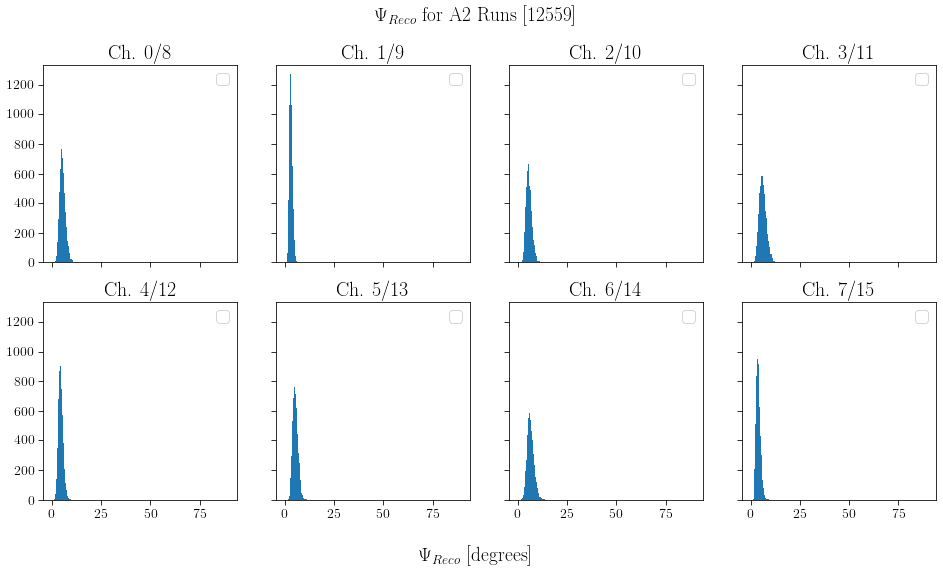

In [10]:
# fig, ax = makeHistogram(polRF.psiReco[pandasToNumpy(polRF.vSNR)>8], bins=np.arange(0,90,0.5), badChannels=[5,7])
fig, ax = makeHistogram(polRF.psiReco, bins=np.arange(0,90,0.5))

fig.suptitle('$\\Psi_{Reco}$ for A' + str(station) + " Runs " + str(runNumbers))
fig.supxlabel("$\\Psi_{Reco}$ [degrees]")
# for axes in ax:
#     axes.set_ylim([0,300])

In [11]:
def find68PercentLimits(array, binNum):
    upperLim = 0
    lowerLim = 0
    data_entries_Om, bins_Om = np.histogram(array, bins=binNum, density=True)
    bin_width = bins_Om[1] - bins_Om[0]
    binMedian = findMedianBin(array, binNum)
#     print('binMedian is %i'%binMedian )
    for bins in range(binNum):
        integral = bin_width * sum(data_entries_Om[binMedian:bins])
        if (integral>0.32): #Shouldn't this be 0.32 if we're finding the 68% limits? - JCF 3/2/2022
            break
        upperLim = bins
    for bins in range(binNum):
        integral = bin_width * sum(data_entries_Om[bins:binMedian])
        if (integral<0.32):
            break
        lowerLim = bins
    return bins_Om[binMedian], bins_Om[lowerLim], bins_Om[upperLim]

def findMedianBin(array, binNum):
    data_entries_Om, bins_Om = np.histogram(array, bins=binNum, density=True)
    bin_width = bins_Om[1] - bins_Om[0]
    median = np.median(array)
    findBin = np.where(abs(bins_Om - median)<bin_width)
    return findBin[0][0]

In [12]:
def singleDeltaVsTrueValue(delta, xValue, label1='delta1', xMax=0, binSize=1, xResolution=1, xCutoff=5):
    x_arr = []

    meanX = []
    upperX = []
    lowerX = []

    #Vpol
    
    if (xMax == 0):
        xMax = int(xValue.max())

    for xTemp in np.arange(xCutoff,int(xMax),xResolution):
        # print("Checking x-value = " + str(xTemp))
        #This grabs SNR values that are within 3 of the current loop value.  Jorge previously had it where it would grab SNR values that are greater than the current loop value.
        x_recoNu = xValue[abs(xValue-xTemp)<=binSize]
        # print(x_recoNu)
        #SNR_recoNu = snrV[snrV>SNR]
    #    SNR_recoNu = pol_new.loc[pol_new.SNR_V>SNR]  #Commenting this out to reproduce the plots in the current draft of the reco paper - JCF 3/1/2022
        x_arr.append(xTemp)

        #Omega
        mean, lower, upper = find68PercentLimits(delta[abs(xValue-xTemp)<=binSize], 300)
        #mean, lower, upper = find68PercentLimits(delta1[snrV>SNR], 300)
        meanX.append(mean)
        upperX.append(upper)
        # lowerX.append(upper)  #This is wrong.  Changing to lower - JCF 5/25/2023
        lowerX.append(lower)
        # print(str(xTemp) + ": " + str(lower) + ', ' +str(mean) + ', ' +str(upper))

    x_arr = np.array(x_arr)

    meanX = np.array(meanX)
    upperX = np.array(upperX)
    lowerX = np.array(lowerX)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24, 12))
    axes.plot(x_arr,meanX, label=label1, color='black')
    # print(meanX)
    # print(lowerX)
    # print(upperX)
    # print(meanX-lowerX) #debugging
    # axes.fill_between(x_arr, meanX-lowerX, meanX+upperX ,alpha=0.4, label = "$68\\%$ events", color='orange') #Debugging -JCF 5/25/2023
    axes.fill_between(x_arr, lowerX, upperX ,alpha=0.4, label = "$68\\%$ events", color='orange')

    #plt.plot(SNR_arr,meanV[1], label=label2)
    #plt.fill_between(SNR_arr, meanV[1]-lowerV[1], meanV[1]+upperV[1] ,alpha=0.4, label = label2 + " $68\\%$ events")

    axes.set_xlabel("$\\Psi_{Expected}$ [degrees]")

    axes.set_ylabel("Median [deg]")
    # axes.axvline(20.3,ls="--",color="green")
    axes.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    axes.legend(loc='upper right')

    #axes[0].set_ylim(-15,15)

    #plt.plot(SNR_arr,meanH[1], label=label2)
    #plt.fill_between(SNR_arr, meanH[1]-lowerH[1], meanH[1]+upperH[1] ,alpha=0.4, label = label2 + " $68\\%$ events")

    #axes[0].plot(resolutionH[0],abs(np.array(resolutionH[2])), label="$\Psi_{reco}-\Psi_{Expected}$ [deg]")
    #axes[0].fill_between(resolutionH[0],abs(np.array(resolutionH[2]))+abs(np.array(resolutionH_err[1])),abs(np.array(resolutionH[2]))-abs(np.array(resolutionH_err[1])),alpha=0.4
    #axes[1].set_ylim(-15,15)
    #plt.legend(loc='upper right')
    #plt.grid()
    #plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    # plt.suptitle("$\Omega = \\tan^{-1}({A_H/A_V})$, SNR$_H>%i$ + SNR$_V>%i$ + saturation cut"%(SNR_cutH,SNR_cutV), fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("$\\Delta \\Psi$ Resolution vs $\\Psi_{Expected}$")
    #plt.savefig('./'+plotFolder+'/'+str(label1)+'And'+str(label2)+'VsSNR_Median_68Pct.png')
    
    return fig, axes

In [13]:
# snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

# psiReco = pandasToNumpy(polRF.psiReco)
# badChannels = [5, 7]
# psiReco = np.delete(psiReco, badChannels, axis=1)
# psiReco = psiReco.mean(axis=1)
# psiTrue = np.empty(psiReco.shape)
# for pair in range(8):
#     psiTrue[:] = pandasToNumpy(polRF.runNumber)
# deltaPsi = psiReco-psiTrue
# fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=1, xResolution=1, xCutoff=0)
# # plt.axvline(45)
# major_ticks = np.arange(0, 95, 5)
# minor_ticks = np.arange(0, 95, 5)
# # ax.set_xticks(major_ticks, fontsize=30)
# # ax.set_xticks(minor_ticks, minor=True)
# # ax.set_yticks(np.arange(-6,16,1))

# labelFontsize = 30
# plt.suptitle("Polarization Angle $\\Psi$ Resolution versus Expected Polarization for Simulated Pulsers Averaged Across Channels 0-4 and 6", fontsize=labelFontsize)
# plt.ylabel("$\\Psi_{Reco} - \\Psi_{Expected}$ [degrees]", fontsize=labelFontsize)
# plt.xlabel("$\\Psi_{Expected}$ [degrees]", fontsize=labelFontsize)
# plt.xticks(major_ticks, fontsize=20)
# plt.yticks(np.arange(-9,14,1), fontsize=20)

# # #Plot SpiceCore reco datapoint
# # spicePsi = 6.886
# # spiceError = [[1.790], [1.343]]
# # plt.errorbar(spicePsi,2,yerr=spiceError)

In [14]:
# snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

# psiReco = pandasToNumpy(polRF.psiReco)

# channel = 0

# psiReco = psiReco[:,channel]

# psiTrue[:] = pandasToNumpy(polRF.runNumber)
# deltaPsi = psiReco-psiTrue
# fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=1, xResolution=1, xCutoff=0)
# # plt.axvline(45)
# major_ticks = np.arange(0, 95, 5)
# minor_ticks = np.arange(0, 95, 5)
# # ax.set_xticks(major_ticks, fontsize=30)
# # ax.set_xticks(minor_ticks, minor=True)
# # ax.set_yticks(np.arange(-6,16,1))

# labelFontsize = 30
# plt.suptitle("Polarization Angle $\\Psi$ Resolution versus Expected Polarization for Simulated Pulsers for Channel " + str(channel), fontsize=labelFontsize)
# plt.ylabel("$\\Psi_{Reco} - \\Psi_{Expected}$ [degrees]", fontsize=labelFontsize)
# plt.xlabel("$\\Psi_{Expected}$ [degrees]", fontsize=labelFontsize)
# plt.xticks(major_ticks, fontsize=20)
# plt.yticks(np.arange(-3,3,1), fontsize=20)

In [15]:
# snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

# psiRecoAll = pandasToNumpy(polRF.psiReco)


# for channel in range(8):
#     psiReco = psiRecoAll[:,channel]

#     psiTrue[:] = pandasToNumpy(polRF.runNumber)
#     deltaPsi = psiReco-psiTrue
#     fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=1, xResolution=1, xCutoff=0)
#     # plt.axvline(45)
#     major_ticks = np.arange(0, 95, 5)
#     minor_ticks = np.arange(0, 95, 5)
#     # ax.set_xticks(major_ticks, fontsize=30)
#     # ax.set_xticks(minor_ticks, minor=True)
#     # ax.set_yticks(np.arange(-6,16,1))

#     labelFontsize = 30
#     plt.suptitle("Polarization Angle $\\Psi$ Resolution versus Expected Polarization for Simulated Pulsers for Channel " + str(channel), fontsize=labelFontsize)
#     plt.ylabel("$\\Psi_{Reco} - \\Psi_{Expected}$ [degrees]", fontsize=labelFontsize)
#     plt.xlabel("$\\Psi_{Expected}$ [degrees]", fontsize=labelFontsize)
#     plt.xticks(major_ticks, fontsize=20)
#     plt.yticks(np.arange(-9,14,1), fontsize=20)
#     plt.show()

([<matplotlib.axis.YTick at 0x2b6b3b3345f0>,
 [Text(0, 4.0, '$\\mathdefault{4.00}$'),
  Text(0, 4.25, '$\\mathdefault{4.25}$'),
  Text(0, 4.5, '$\\mathdefault{4.50}$'),
  Text(0, 4.75, '$\\mathdefault{4.75}$'),
  Text(0, 5.0, '$\\mathdefault{5.00}$'),
  Text(0, 5.25, '$\\mathdefault{5.25}$')])

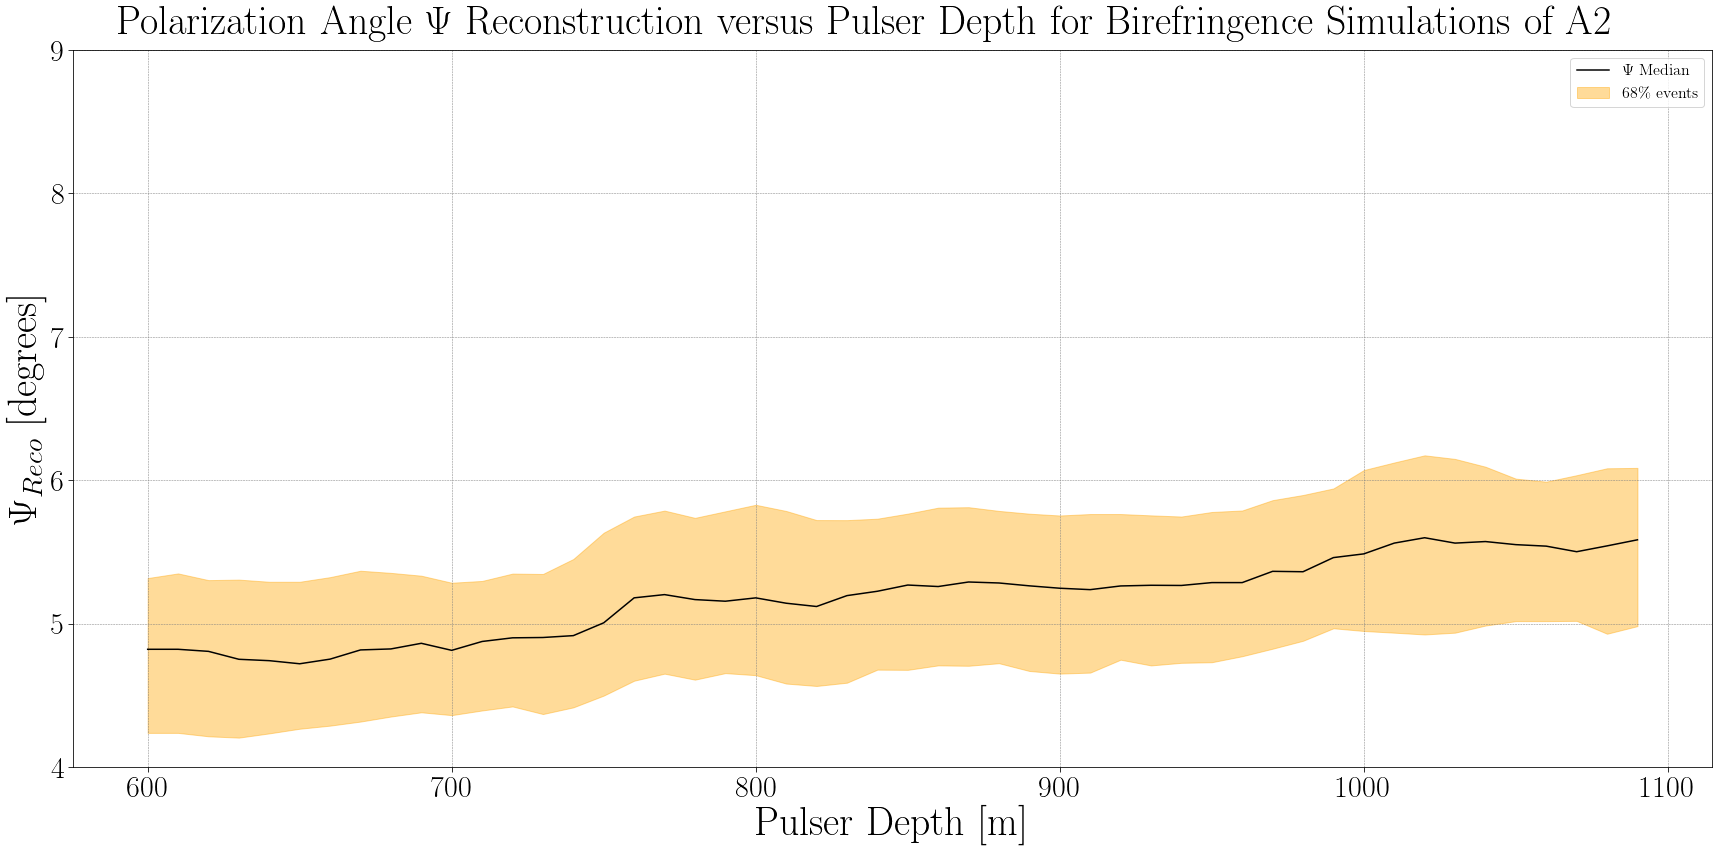

In [16]:
#Make plot with SNR cut
snrMean = pandasToNumpy(polRF.vSNR)

snrCutoff = 8

psiReco = pandasToNumpy(polRF.psiReco)
badChannels = [5, 7]
psiReco = np.delete(psiReco, badChannels, axis=1)
psiReco = psiReco.mean(axis=1)
pulserDepth = np.empty(psiReco.shape)
for pair in range(8):
    pulserDepth[:] = pandasToNumpy(polRF.pulserDepth)
# deltaPsi = psiReco-psiTrue


#Plot paramters for devonvolved data shown in 10/12/2023 reco call
# fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=5, xResolution=1, xCutoff=600)

#Plot paramters after applying timing cut with 0.04 tolerance
fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=10, xResolution=10, xCutoff=600)


#Reco of raw data as a sanity check
# fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=10, xResolution=5, xCutoff=600)
# plt.axvline(45)
major_ticks = np.arange(600, 1200, 100)
minor_ticks = np.arange(600, 1200, 100)
# ax.set_xticks(major_ticks, fontsize=30)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 40
plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for Birefringence Simulations of A2 ", fontsize=labelFontsize)


# plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for RAW A2 Run 12559 SPICE Pulsing (SNR $>$ "+str(snrCutoff)+")", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("Pulser Depth [m]", fontsize=labelFontsize)
plt.xticks(major_ticks, fontsize=30)

#Ticks for deconvolved plot shown in 10/12/2023 reco call
plt.yticks(np.arange(4,10,1), fontsize=30)

#Ticks for sanity check of reconstructino on raw spice data
# plt.yticks(np.arange(5,45,5), fontsize=30)

# #Plot SpiceCore reco datapoint
# spicePsi = 6.886
# spiceError = [[1.790], [1.343]]
# plt.errorbar(spicePsi,2,yerr=spiceError)

([<matplotlib.axis.YTick at 0x2b6b3b3ac280>,
 [Text(0, 3.0, '$\\mathdefault{3.0}$'),
  Text(0, 3.5, '$\\mathdefault{3.5}$'),
  Text(0, 4.0, '$\\mathdefault{4.0}$'),
  Text(0, 4.5, '$\\mathdefault{4.5}$'),
  Text(0, 5.0, '$\\mathdefault{5.0}$'),
  Text(0, 5.5, '$\\mathdefault{5.5}$')])

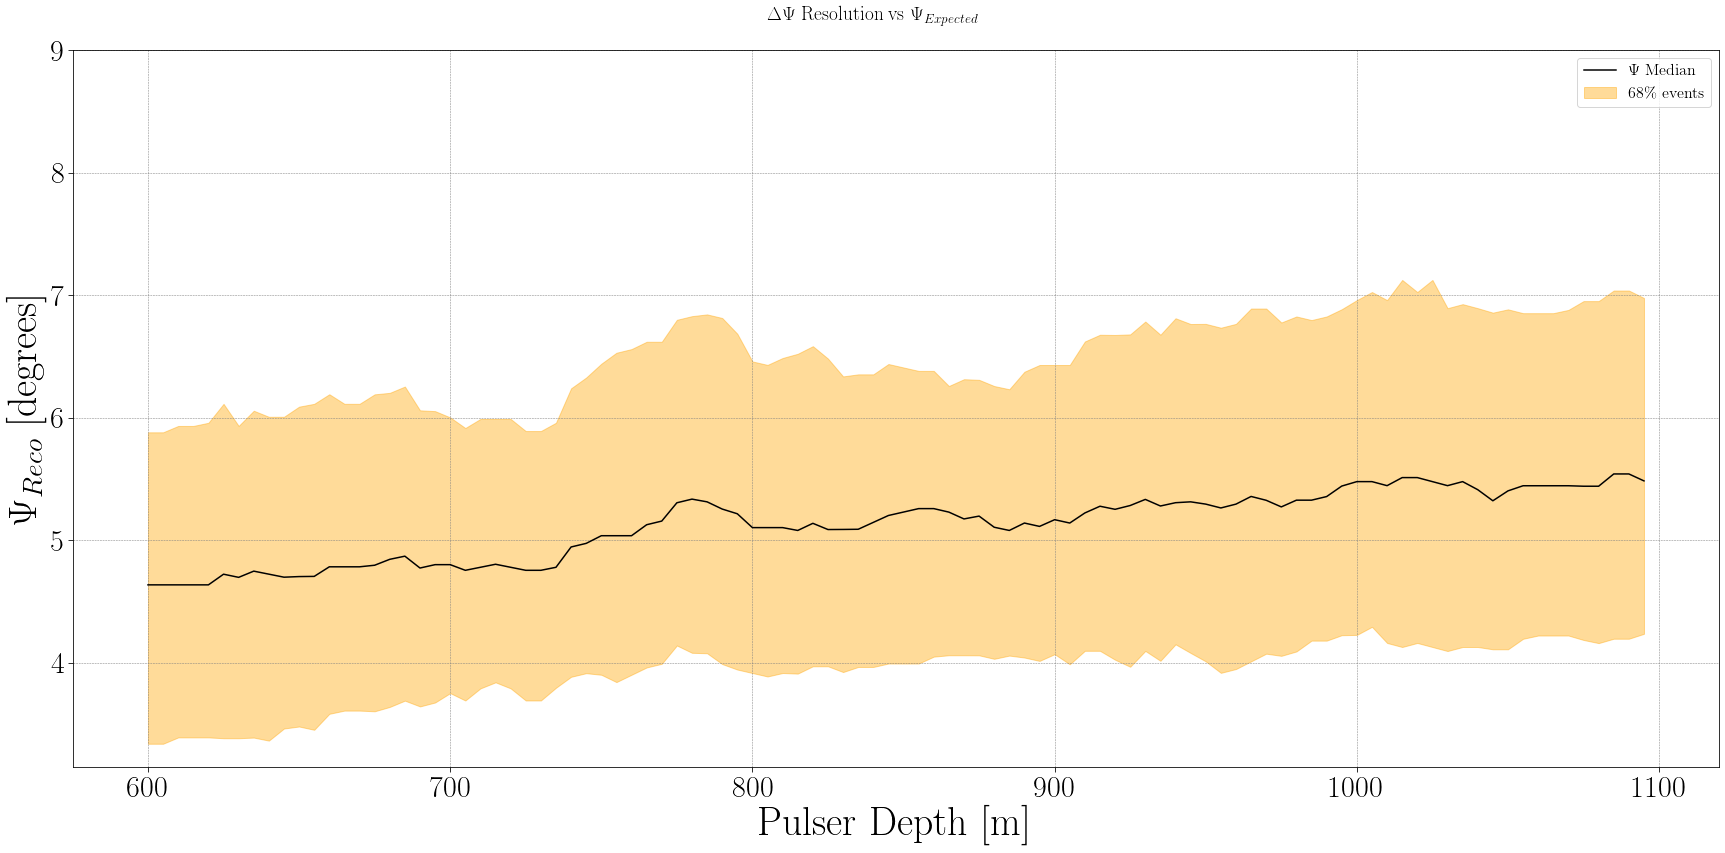

In [17]:
#Make plot with SNR cut
snrMean = pandasToNumpy(polRF.vSNR)

snrCutoff = 5
channelPair=0

psiReco = pandasToNumpy(polRF.psiReco)[:,channelPair]
for pair in range(8):
    pulserDepth[:] = pandasToNumpy(polRF.pulserDepth)
# deltaPsi = psiReco-psiTrue


#Plot paramters for devonvolved data shown in 10/12/2023 reco call
# fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=5, xResolution=1, xCutoff=600)

#Plot paramters after applying timing cut with 0.04 tolerance
fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=20, xResolution=5, xCutoff=600)


#Reco of raw data as a sanity check
# fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=10, xResolution=5, xCutoff=600)
# plt.axvline(45)
major_ticks = np.arange(600, 1200, 100)
minor_ticks = np.arange(600, 1200, 100)
# ax.set_xticks(major_ticks, fontsize=30)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 40
# plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for A2 Run 12559 SPICE Pulsing (SNR $>$ "+str(snrCutoff)+")", fontsize=labelFontsize)


# plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for RAW A2 Run 12559 SPICE Pulsing (SNR $>$ "+str(snrCutoff)+")", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("Pulser Depth [m]", fontsize=labelFontsize)
plt.xticks(major_ticks, fontsize=30)

#Ticks for deconvolved plot shown in 10/12/2023 reco call
plt.yticks(np.arange(4,10,1), fontsize=30)

#Ticks for sanity check of reconstructino on raw spice data
# plt.yticks(np.arange(5,45,5), fontsize=30)

# #Plot SpiceCore reco datapoint
# spicePsi = 6.886
# spiceError = [[1.790], [1.343]]
# plt.errorbar(spicePsi,2,yerr=spiceError)

In [18]:
psiReco.shape

(5100,)

(3.0, 9.0)

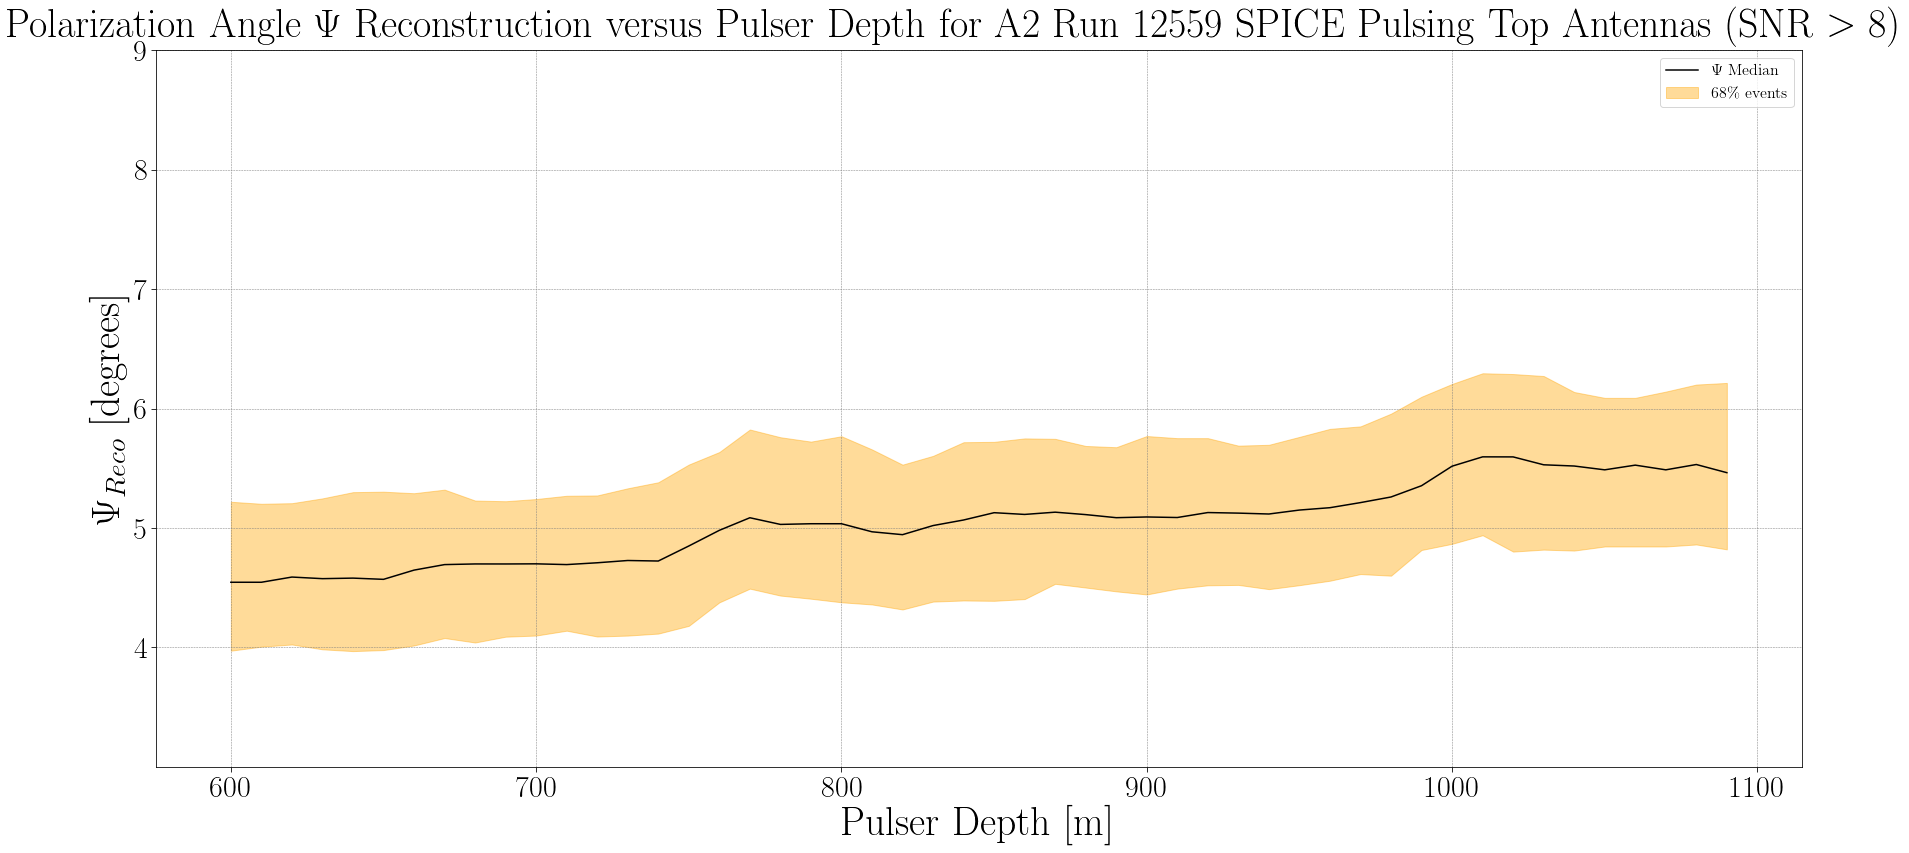

In [19]:
#Make plot with SNR cut
snrMean = pandasToNumpy(polRF.vSNR)

snrCutoff = 8

psiReco = pandasToNumpy(polRF.psiReco)
badChannels = [4, 5, 6, 7]
psiReco = np.delete(psiReco, badChannels, axis=1)
psiReco = psiReco.mean(axis=1)
pulserDepth = np.empty(psiReco.shape)
for pair in range(8):
    pulserDepth[:] = pandasToNumpy(polRF.pulserDepth)
# deltaPsi = psiReco-psiTrue


#Plot paramters for devonvolved data shown in 10/12/2023 reco call
fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=10, xResolution=10, xCutoff=600)


#Reco of raw data as a sanity check
# fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=10, xResolution=5, xCutoff=600)
# plt.axvline(45)
major_ticks = np.arange(600, 1200, 100)
minor_ticks = np.arange(600, 1200, 100)
# ax.set_xticks(major_ticks, fontsize=30)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 40
plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for A2 Run 12559 SPICE Pulsing Top Antennas (SNR $>$ "+str(snrCutoff)+")", fontsize=labelFontsize)


# plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for RAW A2 Run 12559 SPICE Pulsing (SNR $>$ "+str(snrCutoff)+")", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("Pulser Depth [m]", fontsize=labelFontsize)
plt.xticks(major_ticks, fontsize=30)

#Ticks for deconvolved plot shown in 10/12/2023 reco call
plt.yticks(np.arange(4,10,1), fontsize=30)
plt.ylim([3,9])
#Ticks for sanity check of reconstructino on raw spice data
# plt.yticks(np.arange(5,45,5), fontsize=30)

# #Plot SpiceCore reco datapoint
# spicePsi = 6.886
# spiceError = [[1.790], [1.343]]
# plt.errorbar(spicePsi,2,yerr=spiceError)

(3.0, 9.0)

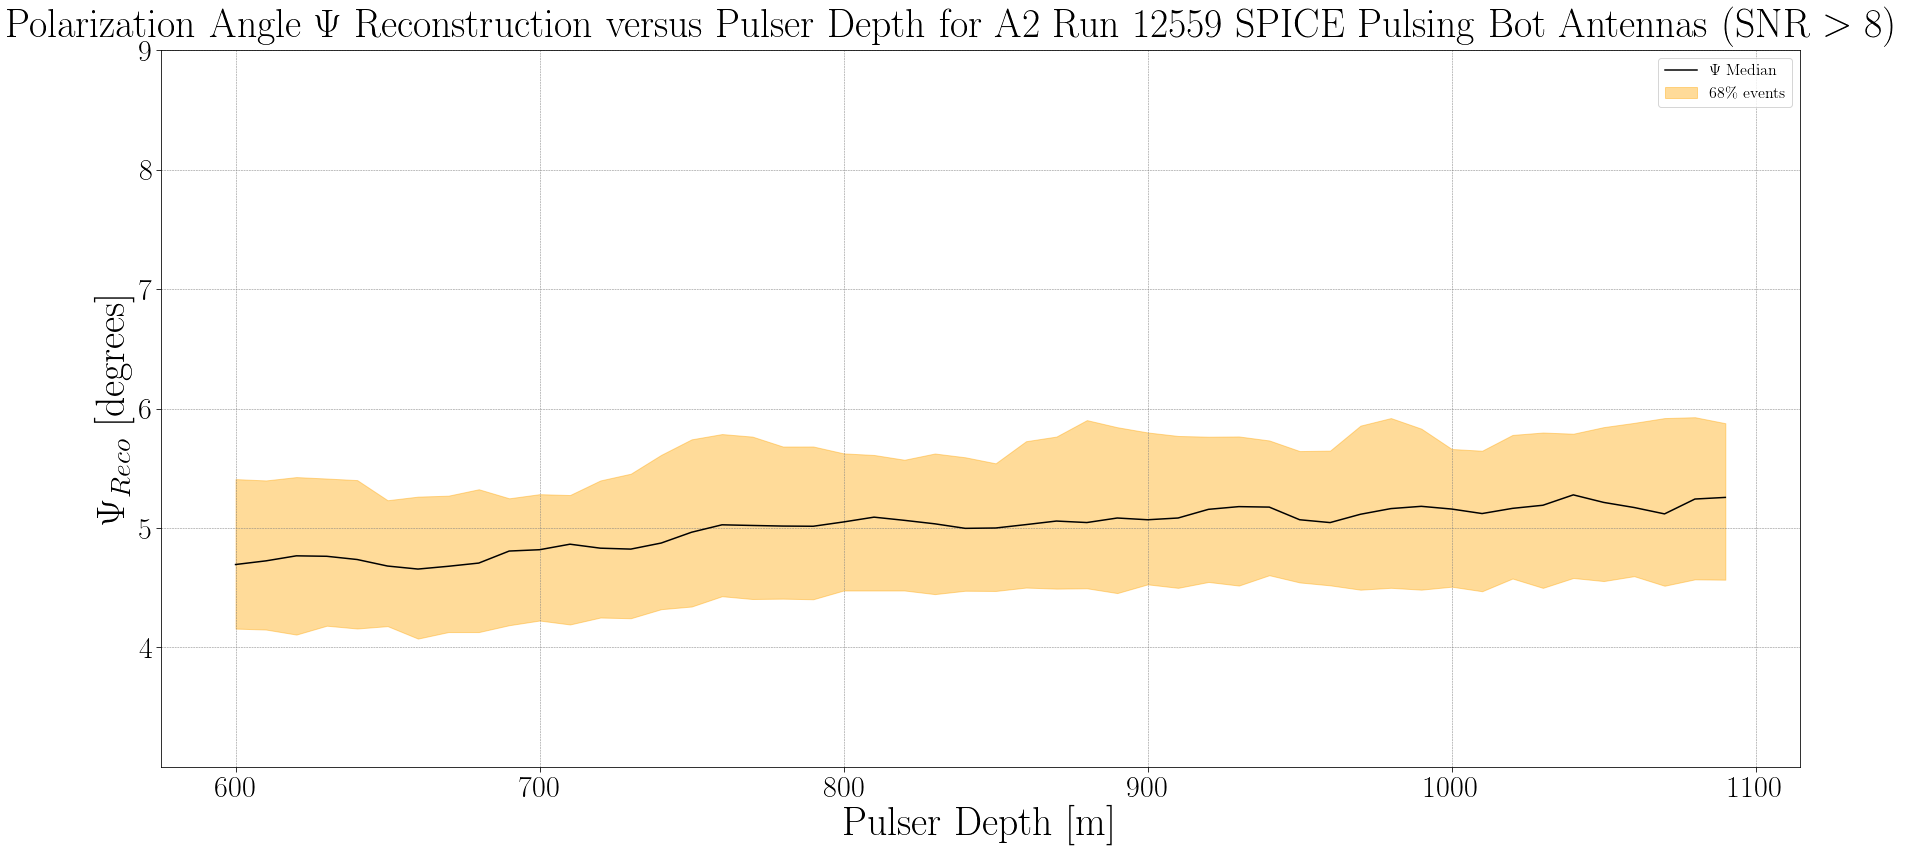

In [20]:
#Make plot with SNR cut
snrMean = pandasToNumpy(polRF.vSNR)

snrCutoff = 8

psiReco = pandasToNumpy(polRF.psiReco)
badChannels = [0,1,2,3]
psiReco = np.delete(psiReco, badChannels, axis=1)
psiReco = psiReco.mean(axis=1)
pulserDepth = np.empty(psiReco.shape)
for pair in range(8):
    pulserDepth[:] = pandasToNumpy(polRF.pulserDepth)
# deltaPsi = psiReco-psiTrue


#Plot paramters for devonvolved data shown in 10/12/2023 reco call
fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=10, xResolution=10, xCutoff=600)


#Reco of raw data as a sanity check
# fig, ax = singleDeltaVsTrueValue(psiReco[snrMean>snrCutoff], pulserDepth[snrMean>snrCutoff], label1='$\\Psi$ Median', xMax=1100, binSize=10, xResolution=5, xCutoff=600)
# plt.axvline(45)
major_ticks = np.arange(600, 1200, 100)
minor_ticks = np.arange(600, 1200, 100)
# ax.set_xticks(major_ticks, fontsize=30)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 40
plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for A2 Run 12559 SPICE Pulsing Bot Antennas (SNR $>$ "+str(snrCutoff)+")", fontsize=labelFontsize)


# plt.suptitle("Polarization Angle $\\Psi$ Reconstruction versus Pulser Depth for RAW A2 Run 12559 SPICE Pulsing (SNR $>$ "+str(snrCutoff)+")", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("Pulser Depth [m]", fontsize=labelFontsize)
plt.xticks(major_ticks, fontsize=30)

#Ticks for deconvolved plot shown in 10/12/2023 reco call
plt.yticks(np.arange(4,10,1), fontsize=30)
plt.ylim([3,9])

#Ticks for sanity check of reconstructino on raw spice data
# plt.yticks(np.arange(5,45,5), fontsize=30)

# #Plot SpiceCore reco datapoint
# spicePsi = 6.886
# spiceError = [[1.790], [1.343]]
# plt.errorbar(spicePsi,2,yerr=spiceError)

In [21]:
def make2dHist(xArray, yArray, snrArray, addMask=0, constrain = None, numBins=50, cmin=1, density=False, snrCutoff=5, xLims=0, yLims=0, xLabel='', yLabel='', title='', fileLabel=''):   
    constrainFolder=''
    if (np.isscalar(addMask) == False):
        xArray = xArray[addMask]
        yArray = yArray[addMask]
        snrArray = snrArray[addMask]
    if (constrain != None):
        constrainFolder = 'constrain' + str(constrain) + '/'
    sns.set(rc = {'figure.figsize':(12,12)},font_scale = 2)
    plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
    plt.colorbar()
    #plt.hist(np.array(psi_reco)-np.array(psi_true), bins = 100)
    plt.title(title + " - SNR $>$ " + str(snrCutoff)+ ", N = " + str(len(np.where(snrArray>snrCutoff)[0])))
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    if (xLims != 0):
        plt.xlim(xLims)
    if (yLims != 0):
        plt.ylim(yLims)

/tmp/ipykernel_1647/3221108592.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
/tmp/ipykernel_1647/3221108592.py:10: UserWarning: Attempting to set identical left == right == 1.106804644422573e+19 results in singular transformations; automatically expanding.
  plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
/tmp/ipykernel_1647/3221108592.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Timestamp [clock units * 1e-8]')

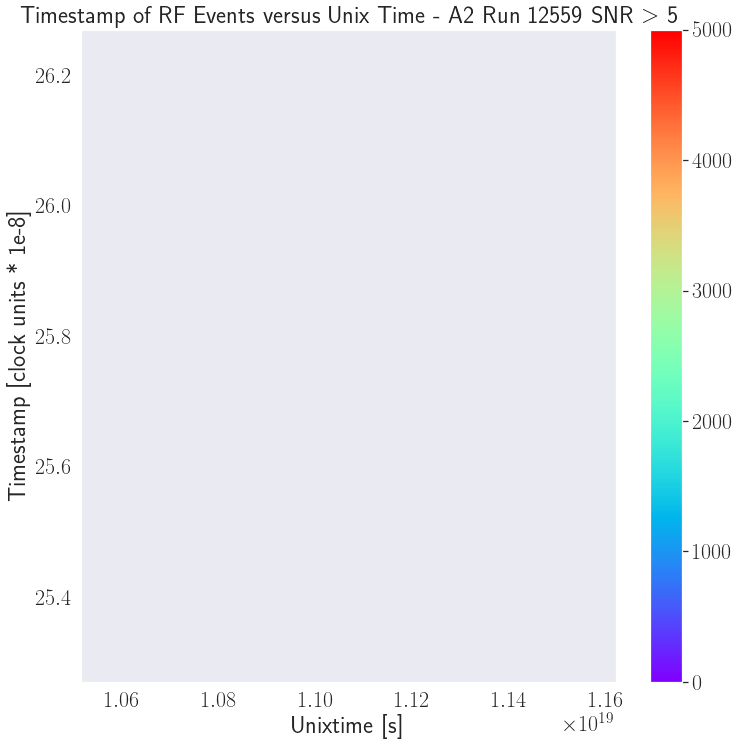

In [22]:
unixtime = pandasToNumpy(polRF.unixtime)
timestamp = pandasToNumpy(polRF.timeStamp)
vSnr = pandasToNumpy(polRF.vSNR)
make2dHist(unixtime, timestamp*1e-8, vSnr, addMask=pulserDepth>600, cmin=0, snrCutoff=5)
plt.title("Timestamp of RF Events versus Unix Time - A2 Run 12559 SNR $>$ 5")
plt.xlabel("Unixtime [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")

/tmp/ipykernel_1647/3221108592.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
/tmp/ipykernel_1647/3221108592.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Timestamp [clock units * 1e-8]')

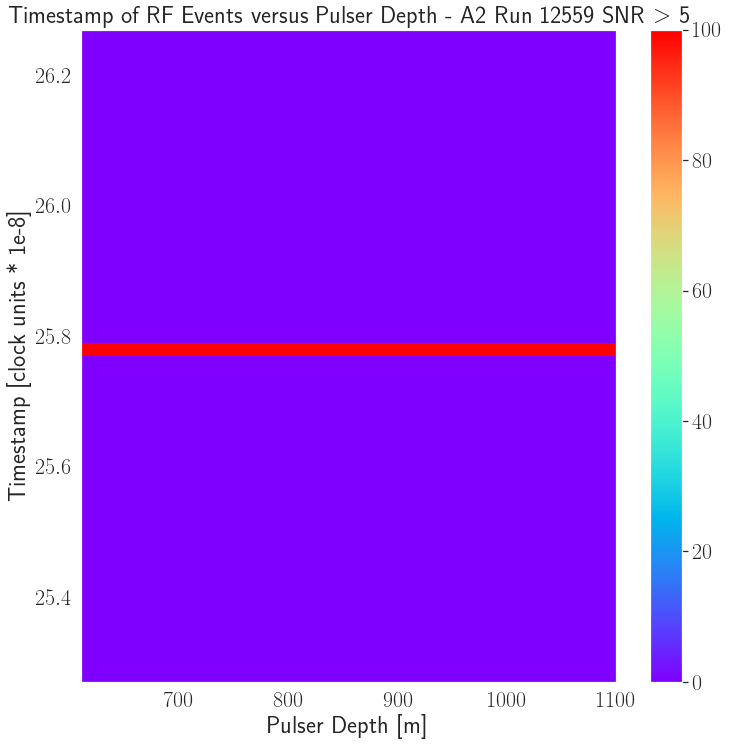

In [23]:
make2dHist(pulserDepth, timestamp*1e-8, vSnr,addMask=pulserDepth>600, cmin=0)
plt.title("Timestamp of RF Events versus Pulser Depth - A2 Run 12559 SNR $>$ 5")
plt.xlabel("Pulser Depth [m]")
plt.ylabel("Timestamp [clock units * 1e-8]")

/tmp/ipykernel_1647/3221108592.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
/tmp/ipykernel_1647/3221108592.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Timestamp [clock units * 1e-8]')

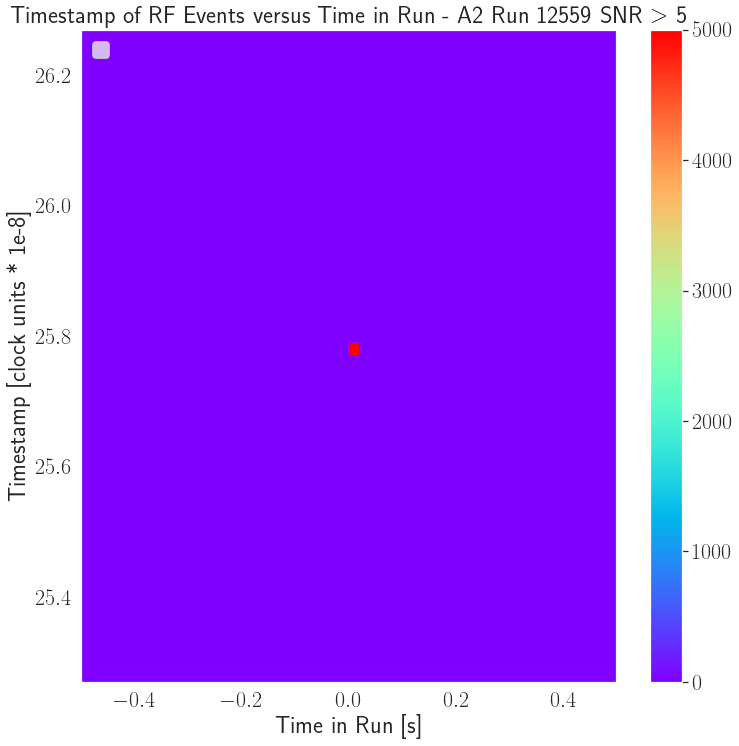

In [24]:
timeInRun = unixtime - unixtime.min() 
make2dHist(timeInRun, timestamp*1e-8, vSnr,addMask=pulserDepth>600, cmin=0, snrCutoff=5)
# plt.axvline(timeMark, color='black', linestyle='-')
sortedTime = np.sort(timeInRun)
modelValues = (0.4+0.004*sortedTime)%1
tolerance = 0.05
# plt.scatter(sortedTime, modelValues, color='black', label='Model')
modelValues = (0.4+(0.004-0.0003646)*sortedTime)%1
# plt.plot(sortedTime, modelValues, color='red', label='Model')
plt.legend(loc='upper left')
plt.title("Timestamp of RF Events versus Time in Run - A2 Run 12559 SNR $>$ 5")
plt.xlabel("Time in Run [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")

/tmp/ipykernel_1647/3221108592.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
/tmp/ipykernel_1647/3221108592.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Timestamp [clock units * 1e-8]')

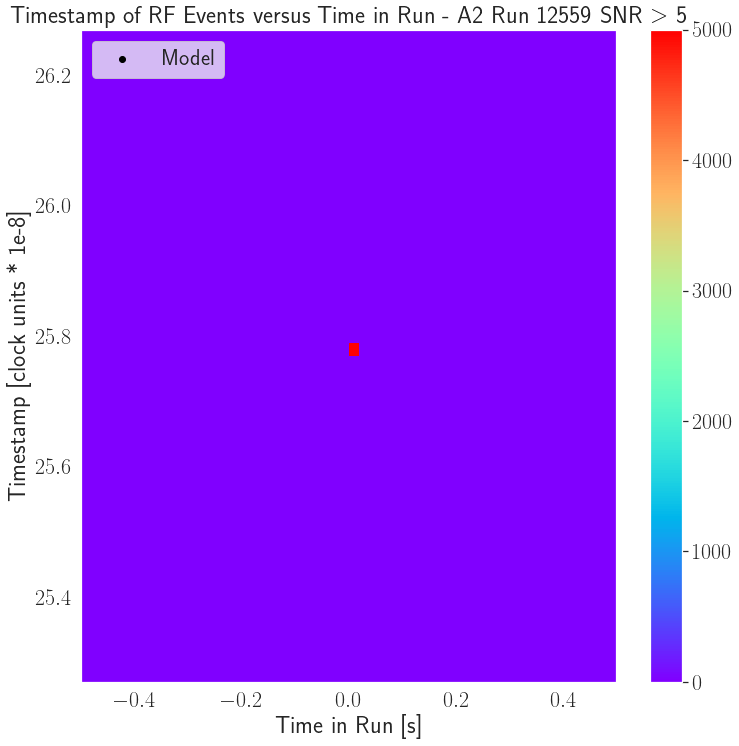

In [25]:
timeInRun = unixtime - unixtime.min() 
make2dHist(timeInRun, timestamp*1e-8, vSnr,addMask=pulserDepth>600, cmin=0, snrCutoff=5)
# plt.axvline(timeMark, color='black', linestyle='-')
sortedTime = np.sort(timeInRun)
modelValues = (0.4+0.004*sortedTime)%1
tolerance = 0.05
plt.scatter(sortedTime, modelValues, color='black', label='Model')
modelValues = (0.4+(0.004-0.0003646)*sortedTime)%1
# plt.plot(sortedTime, modelValues, color='red', label='Model')
plt.legend(loc='upper left')
plt.title("Timestamp of RF Events versus Time in Run - A2 Run 12559 SNR $>$ 5")
plt.xlabel("Time in Run [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")

/tmp/ipykernel_1647/3221108592.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
/tmp/ipykernel_1647/3221108592.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Timestamp [clock units * 1e-8]')

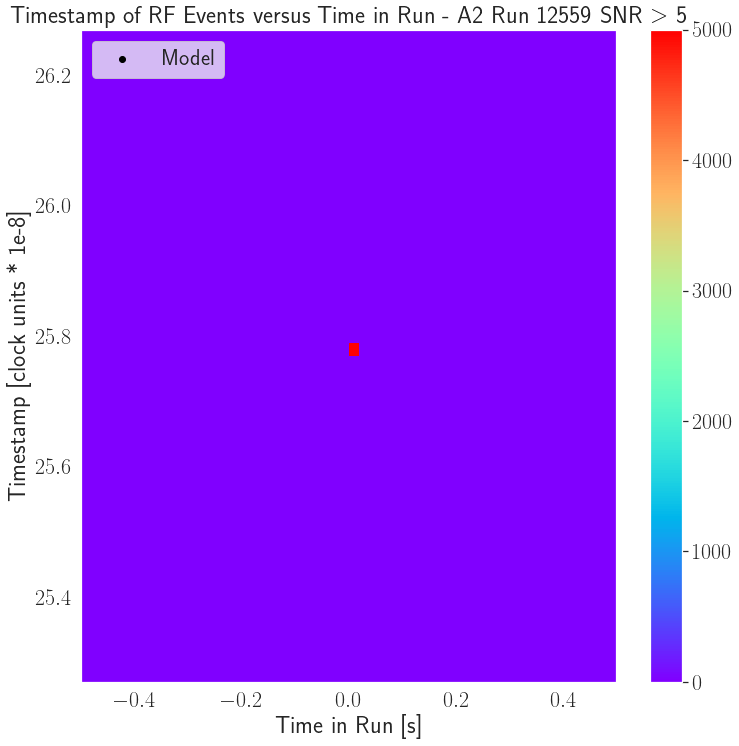

In [26]:
timeInRun = unixtime - unixtime.min() 
tolerance=0.1
make2dHist(timeInRun, timestamp*1e-8, vSnr,addMask=pulserDepth>600, cmin=0, snrCutoff=5)
# plt.axvline(timeMark, color='black', linestyle='-')
sortedTime = np.sort(timeInRun)
modelValues = (0.4+0.004*sortedTime)%1
tolerance = 0.05
plt.scatter(sortedTime, modelValues, color='black', label='Model')
# modelValues = (0.4+(0.004-0.0003646)*sortedTime)%1
# plt.scatter(sortedTime, modelValues, color='red', label='Model')
plt.legend(loc='upper left')
plt.title("Timestamp of RF Events versus Time in Run - A2 Run 12559 SNR $>$ 5")
plt.xlabel("Time in Run [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")

/tmp/ipykernel_1647/3221108592.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(xArray[snrArray>snrCutoff], yArray[snrArray>snrCutoff], bins=numBins, cmin=cmin, density=density, cmap='rainbow')
/tmp/ipykernel_1647/3221108592.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Timestamp [clock units * 1e-8]')

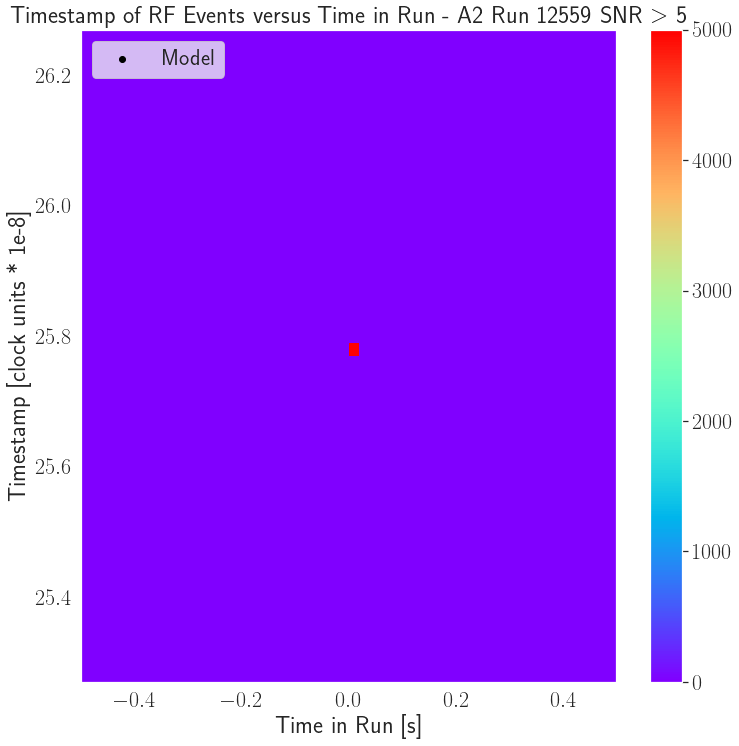

In [27]:
timeInRun = unixtime - unixtime.min() 
tolerance=0.1
make2dHist(timeInRun, timestamp*1e-8, vSnr,addMask=pulserDepth>600, cmin=0, snrCutoff=5)
# plt.axvline(timeMark, color='black', linestyle='-')
sortedTime = np.sort(timeInRun)
modelValues = (0.4+0.004*sortedTime)%1
# tolerance = 0.2
plt.scatter(sortedTime, modelValues, color='black', label='Model')
plt.scatter(sortedTime, (timeStampFit(sortedTime)+tolerance)%1, color='red')
plt.scatter(sortedTime, (timeStampFit(sortedTime)-tolerance)%1, color='green')
# modelValues = (0.4+(0.004-0.0003646)*sortedTime)%1
# plt.scatter(sortedTime, modelValues, color='red', label='Model')
plt.legend(loc='upper left')
plt.title("Timestamp of RF Events versus Time in Run - A2 Run 12559 SNR $>$ 5")
plt.xlabel("Time in Run [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")

(0.0, 500.0)

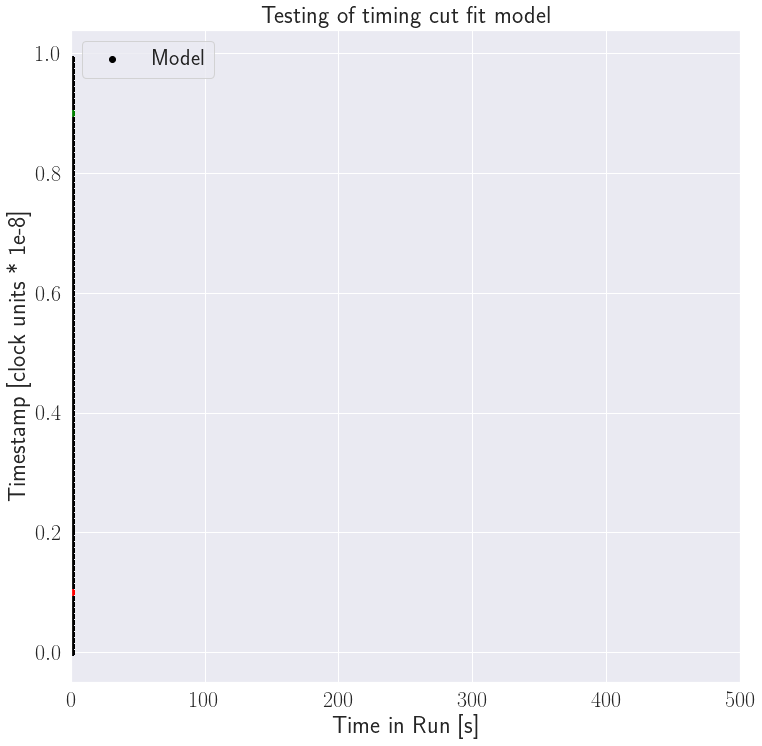

In [28]:
timeInRun = unixtime - unixtime.min() 
tolerance=0.1
# make2dHist(timeInRun, timestamp*1e-8, vSnr,addMask=pulserDepth>600, cmin=0, snrCutoff=5)
# plt.axvline(timeMark, color='black', linestyle='-')
sortedTime = np.sort(timeInRun)
modelValues = (0.4+0.004*sortedTime)%1
# tolerance = 0.1
rng = np.random.randint(100, size=len(sortedTime))/100
plt.scatter(sortedTime, rng, color='black', label='Model')
# plt.scatter(sortedTime-10, modelValues, color='red', label='Model')
# plt.scatter(sortedTime, upperLimit, color='red')
plt.scatter(sortedTime, (timeStampFit(sortedTime)+tolerance)%1, color='red')
plt.scatter(sortedTime, (timeStampFit(sortedTime)-tolerance)%1, color='green')
# modelValues = (0.4+(0.004-0.0003646)*sortedTime)%1
# plt.scatter(sortedTime, modelValues, color='red', label='Model')
plt.legend(loc='upper left')
plt.title("Testing of timing cut fit model")
plt.xlabel("Time in Run [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")
plt.xlim([0,500])

(0.0, 3000.0)

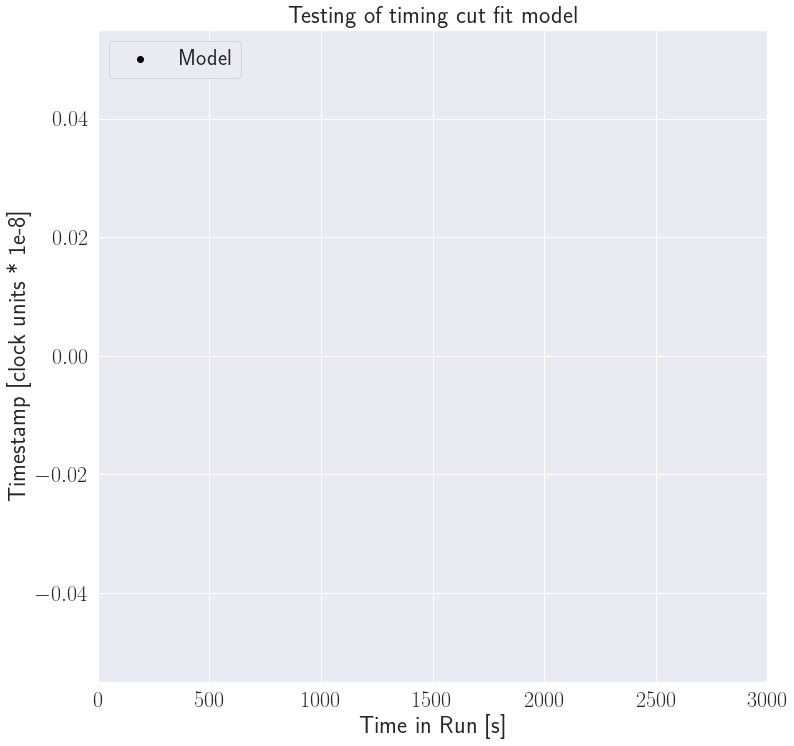

In [29]:
timeInRun = unixtime - unixtime.min() 
tolerance=0.04
sortedTime = np.sort(timeInRun)
modelValues = (0.4+0.004*sortedTime)%1

#Make filtering mechanism for points outside accepted range.
upperLimit=(timeStampFit(timeInRun)+tolerance)%1
lowerLimit=(timeStampFit(timeInRun)-tolerance)%1

mask = (timestamp*1e-8 < upperLimit)
mask *= (timestamp*1e-8 > lowerLimit)


plt.scatter(timeInRun[mask], timestamp[mask]*1e-8, color='black', label='Model')
# plt.scatter(sortedTime-10, modelValues, color='red', label='Model')
# plt.scatter(sortedTime, upperLimit, color='red')
# plt.scatter(timeInRun, upperLimit, color='red')
# plt.scatter(timeInRun, lowerLimit, color='green')
# modelValues = (0.4+(0.004-0.0003646)*sortedTime)%1
# plt.scatter(sortedTime, modelValues, color='red', label='Model')
plt.legend(loc='upper left')
plt.title("Testing of timing cut fit model")
plt.xlabel("Time in Run [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")
plt.xlim([0,3000])

(0.0, 500.0)

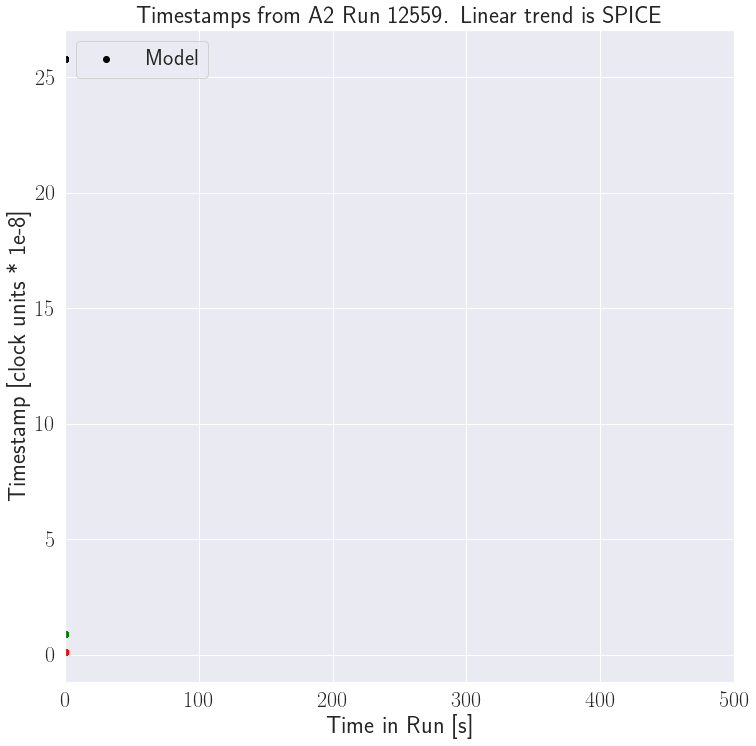

In [30]:
timeInRun = unixtime - unixtime.min() 
tolerance=0.1
# make2dHist(timeInRun, timestamp*1e-8, vSnr,addMask=pulserDepth>600, cmin=0, snrCutoff=5)
# plt.axvline(timeMark, color='black', linestyle='-')
sortedTime = np.sort(timeInRun)
modelValues = (0.4+0.004*sortedTime)%1
# tolerance = 0.1
rng = np.random.randint(100, size=len(sortedTime))/100
plt.scatter(timeInRun, timestamp*1e-8, color='black', label='Model')
# plt.scatter(sortedTime-10, modelValues, color='red', label='Model')
# plt.scatter(sortedTime, upperLimit, color='red')
plt.scatter(sortedTime, (timeStampFit(sortedTime)+tolerance)%1, color='red')
plt.scatter(sortedTime, (timeStampFit(sortedTime)-tolerance)%1, color='green')
# modelValues = (0.4+(0.004-0.0003646)*sortedTime)%1
# plt.scatter(sortedTime, modelValues, color='red', label='Model')
plt.legend(loc='upper left')
plt.title("Timestamps from A2 Run 12559. Linear trend is SPICE")
plt.xlabel("Time in Run [s]")
plt.ylabel("Timestamp [clock units * 1e-8]")
plt.xlim([0,500])